In [1]:
import torch
import numpy as np
import os
import datetime
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from torch.optim import lr_scheduler
import matplotlib.ticker as ticker


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_on_gpu=torch.cuda.is_available()

print(train_on_gpu)

now = str(datetime.datetime.now()).split('.')[0].replace(":", "-")
base_path = "./model_result/resnet/"
os.makedirs(base_path+now)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True


Load the Data

In [2]:
number_of_workers = 0
batch_size= 100
valid_size= 0.2

# Hyper-parameters
n_epochs = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [3]:
# Downloading training and testing Datasets
train_data= datasets.CIFAR10('./data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('./data', train = False,
                             download = True, transform= transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 33225018.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# 打乱索引顺序
split = int(np.floor(valid_size * num_train))
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]

In [5]:
# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,
                                           sampler= train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data , batch_size= batch_size,
                                          sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size, 
                                         num_workers= number_of_workers)

In [7]:
# After preparing Data, we have to unnormalize it to visullize it.
# Let‘s create a helper function which will un-normalize all the images
def imshow(img):
  # Will take numpy array as input
  img = img / 2 + 0.5 # Unnormalize image
  plt.imshow(np.transpose(img, (1, 2, 0))) # img array , axis in tuple(numbers indicates the location of new image shape.) Converting from tensor image 

In [8]:
class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [9]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# create a complete CNN
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [10]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3, verbose=True)

In [11]:
t0 = time.time()

# keeping track of losses as it happen
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
learning_rates = []  # List to store learning rates


valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    correct = 0
    total = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class (get the index of the max probability)
        _, predicted = torch.max(model(data), 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    valid_accuracy = 100 * correct / total
    valid_accuracies.append(valid_accuracy)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    print('Epoch: {} \tTraining Accuracy: {:.2f}% \tValidation Accuracy: {:.2f}%'.format(
    epoch, train_accuracy, valid_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    # Step the scheduler with the average validation loss
    scheduler.step(valid_loss)
    
    # Record the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

t1 = time.time()
print('Time cost: ', t1 - t0)

Epoch: 1 	Training Loss: 1.202938 	Validation Loss: 0.254997
Epoch: 1 	Training Accuracy: 46.46% 	Validation Accuracy: 46.46%
Validation loss decreased (inf --> 0.254997).  Saving model ...
Epoch: 2 	Training Loss: 0.858155 	Validation Loss: 0.265639
Epoch: 2 	Training Accuracy: 63.66% 	Validation Accuracy: 63.66%
Epoch: 3 	Training Loss: 0.740247 	Validation Loss: 0.190555
Epoch: 3 	Training Accuracy: 69.32% 	Validation Accuracy: 69.32%
Validation loss decreased (0.254997 --> 0.190555).  Saving model ...
Epoch: 4 	Training Loss: 0.654762 	Validation Loss: 0.170345
Epoch: 4 	Training Accuracy: 73.42% 	Validation Accuracy: 73.42%
Validation loss decreased (0.190555 --> 0.170345).  Saving model ...
Epoch: 5 	Training Loss: 0.591957 	Validation Loss: 0.149997
Epoch: 5 	Training Accuracy: 76.42% 	Validation Accuracy: 76.42%
Validation loss decreased (0.170345 --> 0.149997).  Saving model ...
Epoch: 6 	Training Loss: 0.546226 	Validation Loss: 0.148842
Epoch: 6 	Training Accuracy: 78.44% 	V

In [12]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

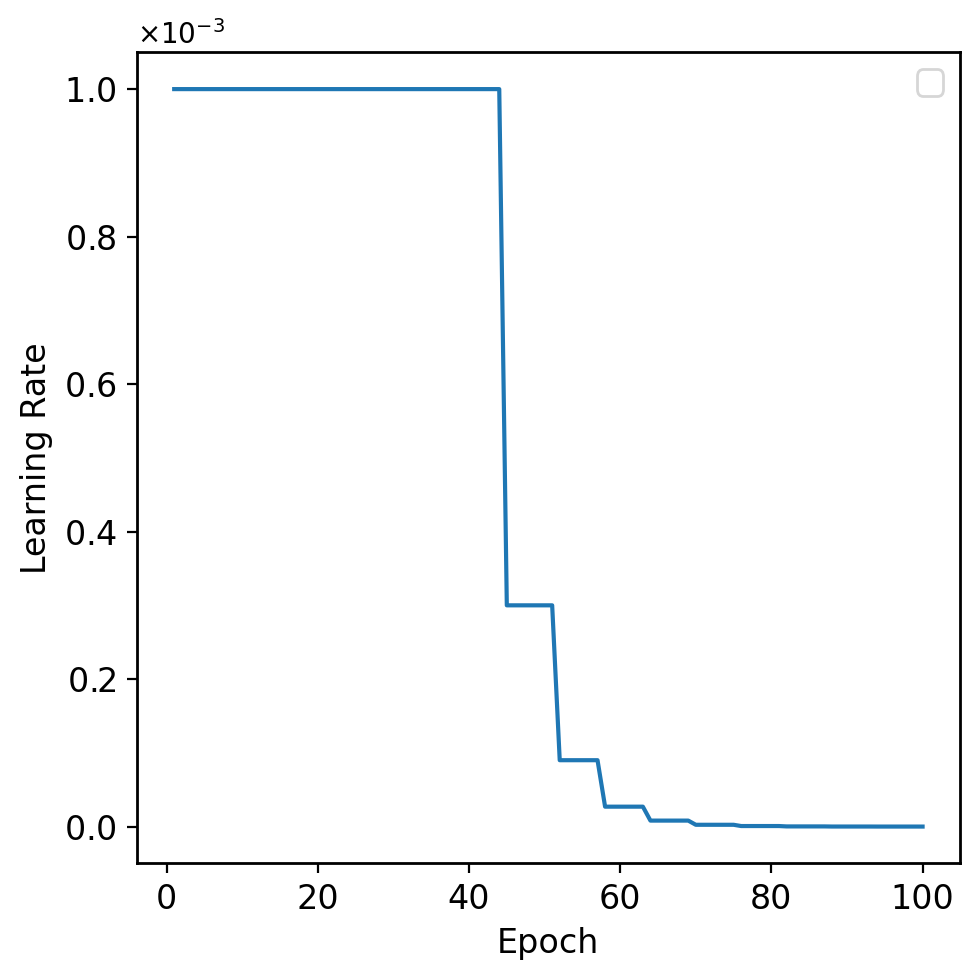

In [13]:
# Set font sizes
fontsize = 12

plt.figure(figsize=(5, 5), dpi=200)
plt.plot(range(1, n_epochs + 1), learning_rates)

# Set title and labels with specific color
plt.xlabel('Epoch', color='black', fontsize=fontsize)
plt.ylabel('Learning Rate', color='black', fontsize=fontsize)

# Set the color of the ticks
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Format y-axis ticks
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='scientific', scilimits=(-1,1))

# Set grid to false
plt.grid(False)
plt.tight_layout()

# Add legend with increased font size
plt.legend(fontsize=fontsize)

# Create a black border around the plot
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "lr_resnet.png")

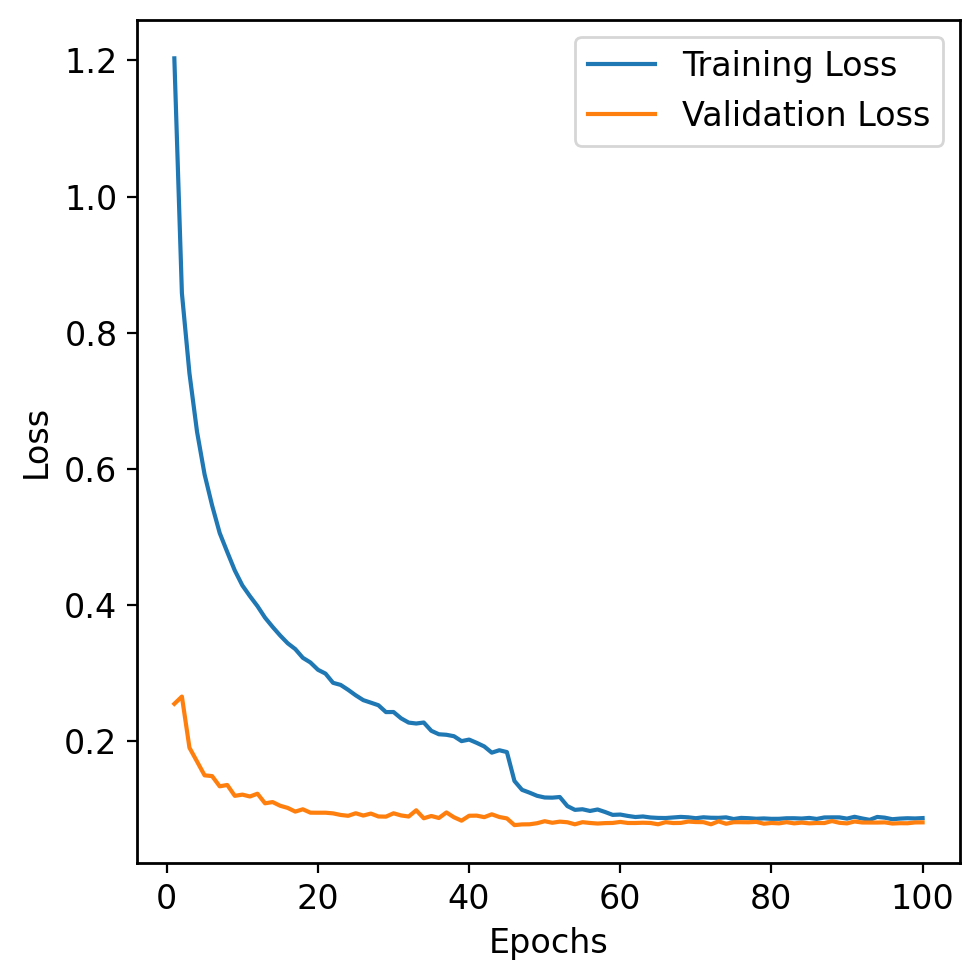

In [14]:
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(5, 5), dpi=200)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

# Set title and labels with black color
plt.xlabel('Epochs', color='black', fontsize=fontsize)
plt.ylabel('Loss', color='black', fontsize=fontsize)

# Set the color of the ticks
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Add legend
plt.legend(fontsize=fontsize)

# Set grid to false
plt.grid(False)
plt.tight_layout()

# Create a black border around the plot
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "loss_resnet.png")

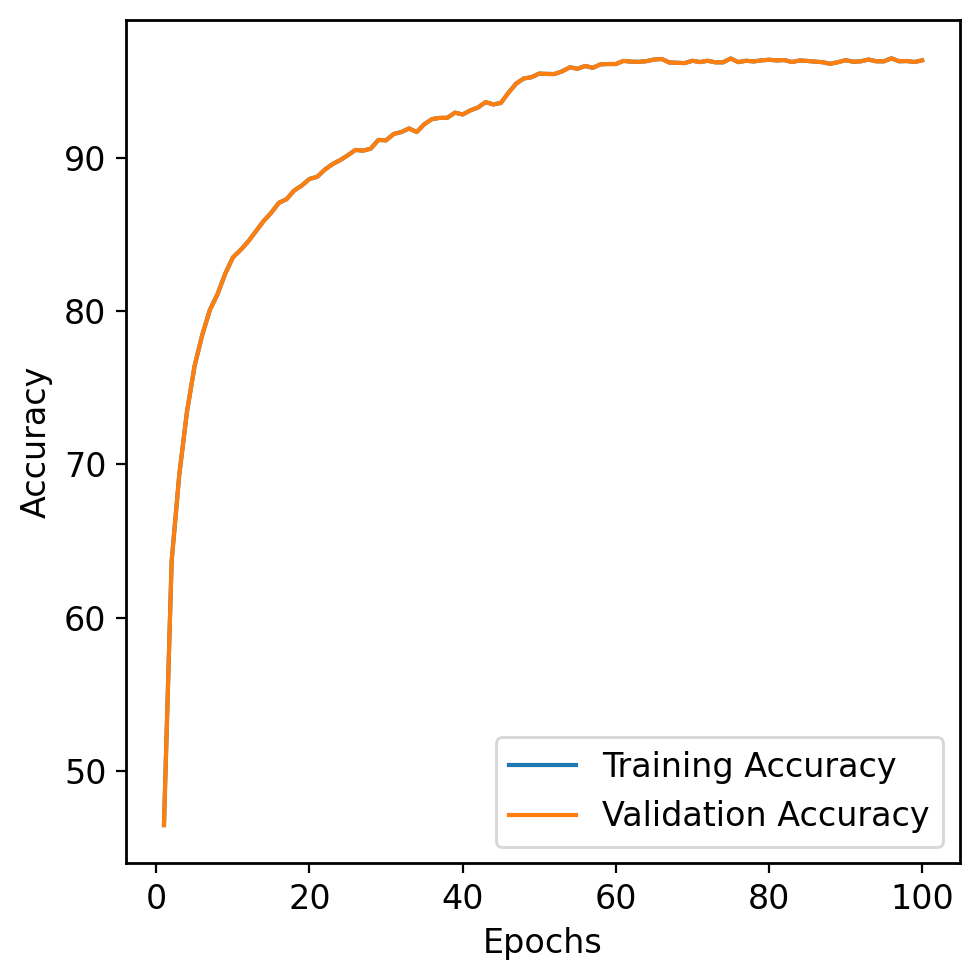

In [15]:
plt.figure(figsize=(5, 5), dpi=200)

# Plotting the accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')

# Set title and labels with specific color
plt.xlabel('Epochs', color='black', fontsize=fontsize)
plt.ylabel('Accuracy', color='black', fontsize=fontsize)

# Set the color of the ticks
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Adding the legend
plt.legend(fontsize=fontsize)

# Setting grid to false
plt.grid(False)
plt.tight_layout()


# Create a black border around the plot
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "accuracy_resnet.png")

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
confusion_matrix = np.zeros((10, 10))
# Dictionaries to store examples
correct_examples = {}
incorrect_examples = {}

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # Update confusion matrix
    for label, prediction in zip(target.view(-1), pred.view(-1)):
        confusion_matrix[label.long(), prediction.long()] += 1
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
    # Store examples of correct and incorrect predictions
    for i in range(data.size(0)):
        label = target.data[i].item()
        pred_label = pred[i].item()
        if pred_label == label and label not in correct_examples:
            correct_examples[label] = (data[i].cpu(), pred_label)
        elif pred_label != label and label not in incorrect_examples:
            incorrect_examples[label] = (data[i].cpu(), pred_label)
    
confusion_matrix = confusion_matrix.astype(int)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.383931

Test Accuracy of Airplane: 89% (891/1000)
Test Accuracy of Automobile: 93% (935/1000)
Test Accuracy of  Bird: 82% (820/1000)
Test Accuracy of   Cat: 76% (763/1000)
Test Accuracy of  Deer: 87% (875/1000)
Test Accuracy of   Dog: 82% (827/1000)
Test Accuracy of  Frog: 90% (905/1000)
Test Accuracy of Horse: 89% (896/1000)
Test Accuracy of  Ship: 92% (924/1000)
Test Accuracy of Truck: 92% (924/1000)

Test Accuracy (Overall): 87% (8760/10000)


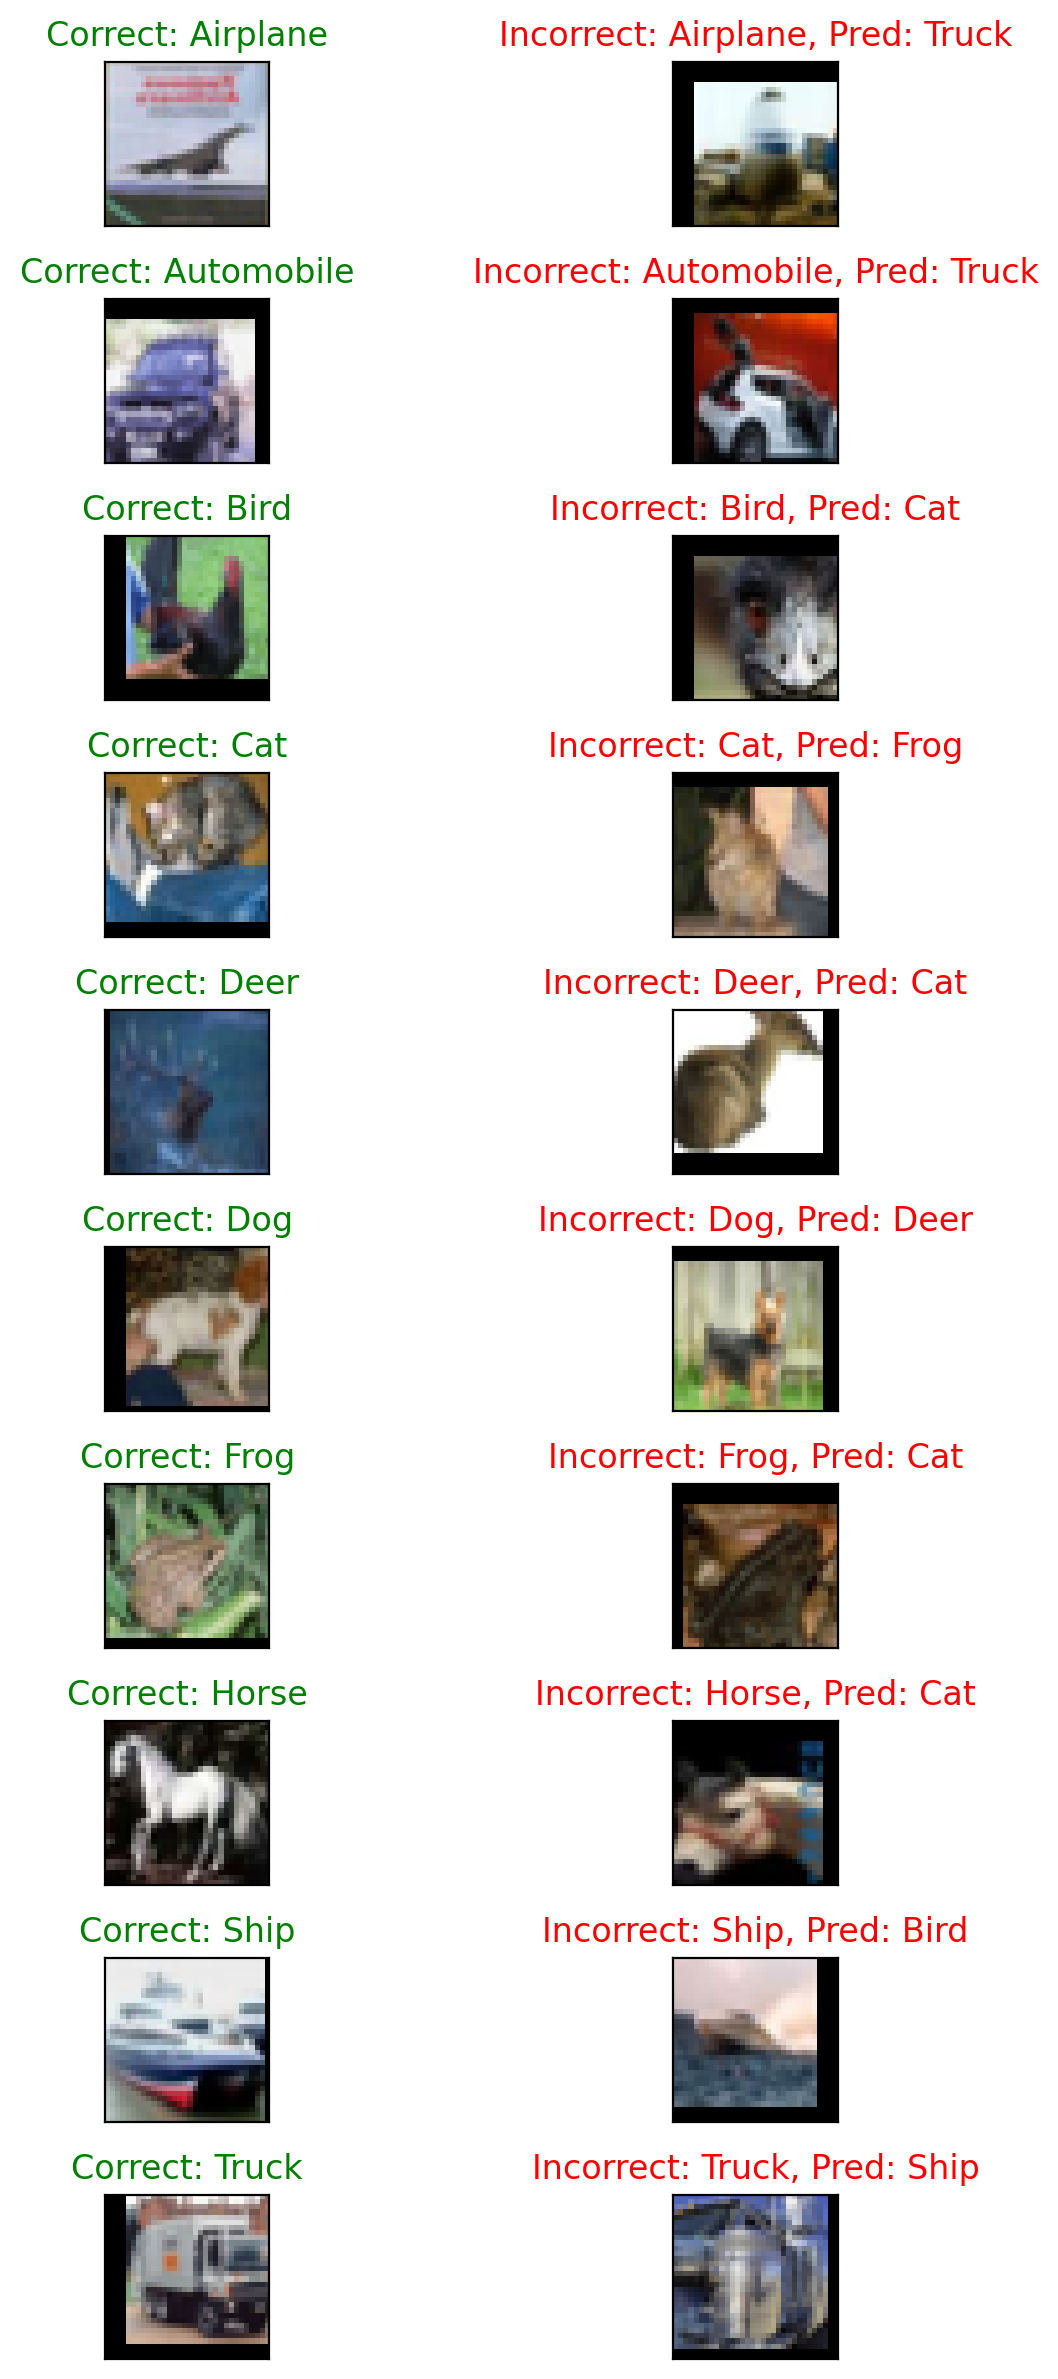

In [17]:
# Adjust the overall figure size here
fig = plt.figure(figsize=(8, 12), dpi=200)  # Reduced figure size

for i in range(10):
    # Correct examples
    ax = fig.add_subplot(10, 2, 2*i + 1, xticks=[], yticks=[])
    if i in correct_examples:
        image, _ = correct_examples[i]
        ax.imshow(image.numpy().transpose((1, 2, 0)))  # Adjust this for your data
        ax.set_title(f"Correct: {class_names[i]}", color="green")

    # Incorrect examples
    ax = fig.add_subplot(10, 2, 2*i + 2, xticks=[], yticks=[])
    if i in incorrect_examples:
        image, pred = incorrect_examples[i]
        ax.imshow(image.numpy().transpose((1, 2, 0)))  # Adjust this for your data
        ax.set_title(f"Incorrect: {class_names[i]}, Pred: {class_names[pred]}", color="red")

# Adjust subplot parameters to reduce space between them
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)

plt.tight_layout()
# plt.show()
plt.savefig(base_path + "correct_prediction_class_resnet")

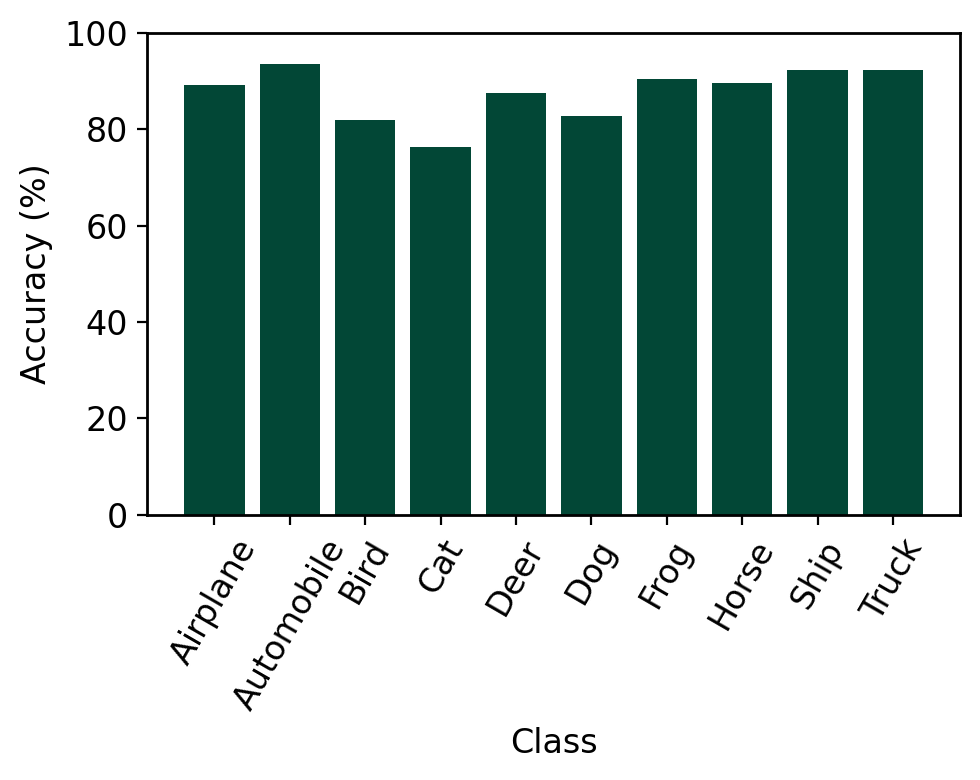

In [18]:
# Calculate the percentage accuracy for each class
class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] else 0 for i in range(10)]

plt.figure(figsize=(5,4), dpi=200)
plt.bar(class_names, class_accuracy, color='#024736')

# Set title and labels with black color
plt.xlabel('Class', color='black', fontsize=fontsize)
plt.ylabel('Accuracy (%)', color='black', fontsize=fontsize)

# Set the color of the ticks to black
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Rotate x-ticks and set y-axis limit
plt.xticks(rotation=60)
plt.ylim([0, 100])  # Limit y-axis to 0-100% for clarity


# Set grid to false and create a black border around the plot
plt.grid(False)
plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Show and save the plot
# plt.show()
plt.savefig(base_path + "accuracy_bar_resnet.png")

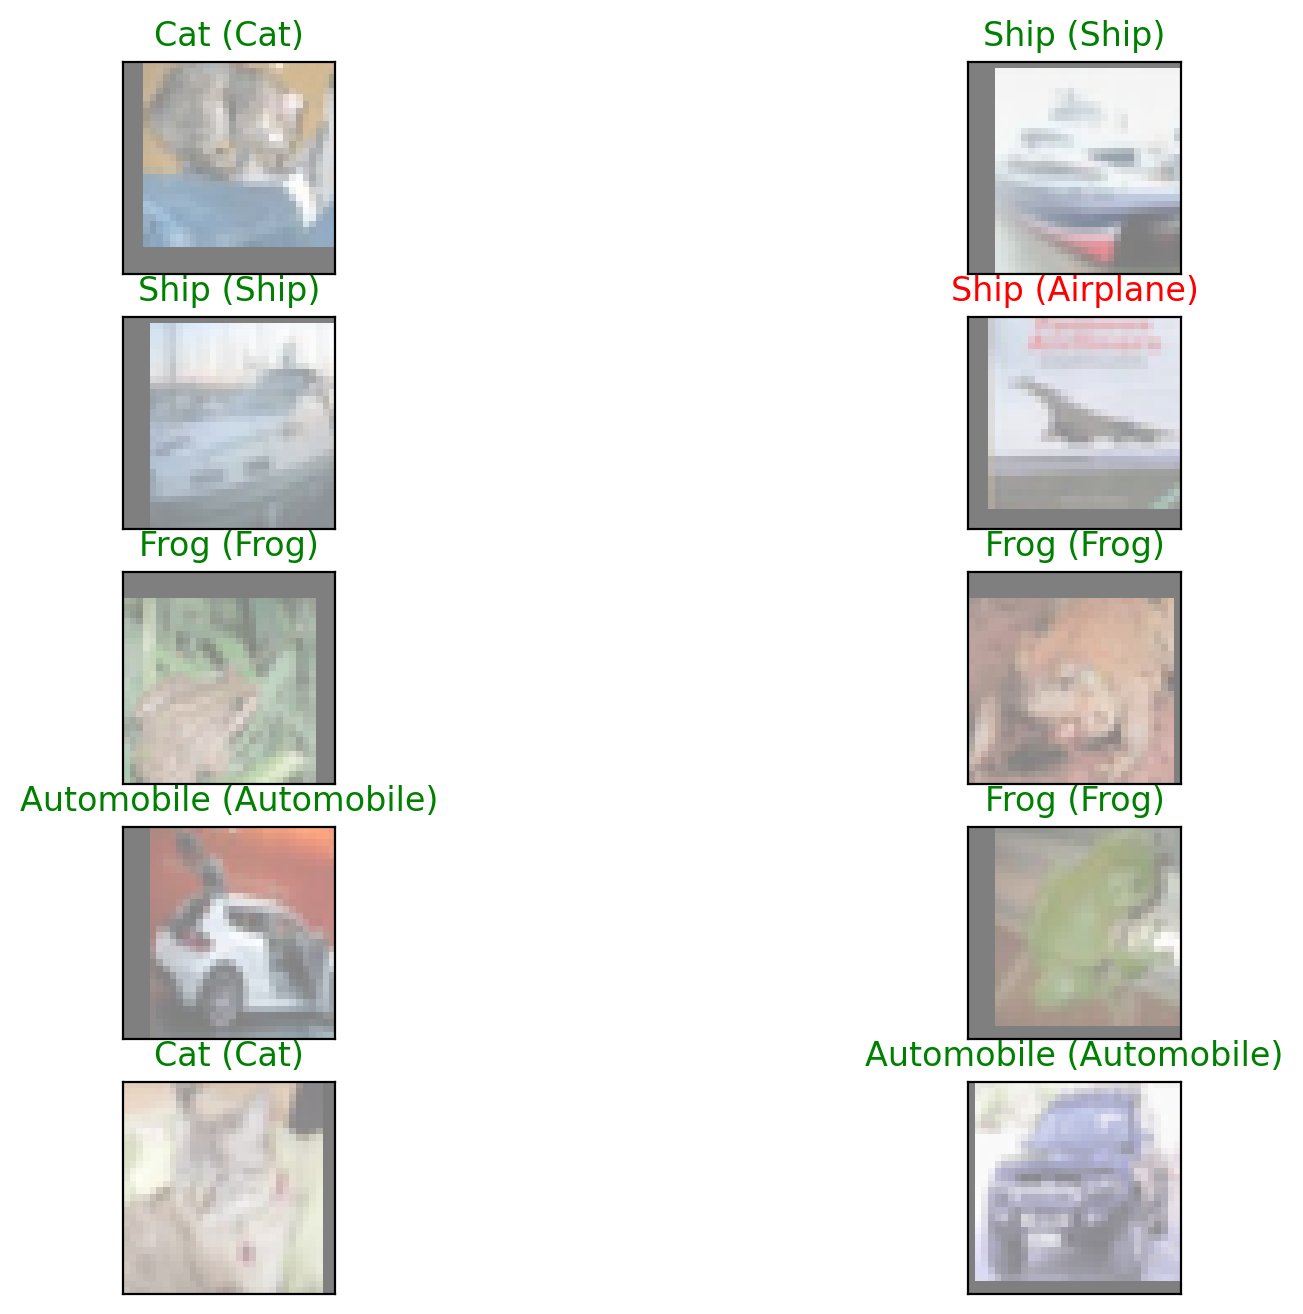

In [19]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

fig = plt.figure(figsize=(10, 8), dpi=200)  # Adjust the figure size as needed
plt.tight_layout()

for idx in np.arange(10):
    ax = fig.add_subplot(5, 2, idx + 1, xticks=[], yticks=[])  # 3 rows and 4 columns
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
plt.savefig(base_path + "batch_test_image_resnet")

Confusion Matrix:
 [[891   9  25  14   6   3   2   7  26  17]
 [  8 935   2   2   1   1   2   0  10  39]
 [ 37   1 820  35  36  27  23  12   6   3]
 [ 14   3  37 763  32 100  16  20   9   6]
 [  4   2  32  32 875  20  13  19   3   0]
 [  4   0  13 100  28 827   7  17   2   2]
 [  9   1  18  39  12  11 905   1   2   2]
 [ 10   1  10  29  27  19   1 896   2   5]
 [ 43   9   4   4   1   2   2   0 924  11]
 [ 14  40   3   2   0   2   1   0  14 924]]


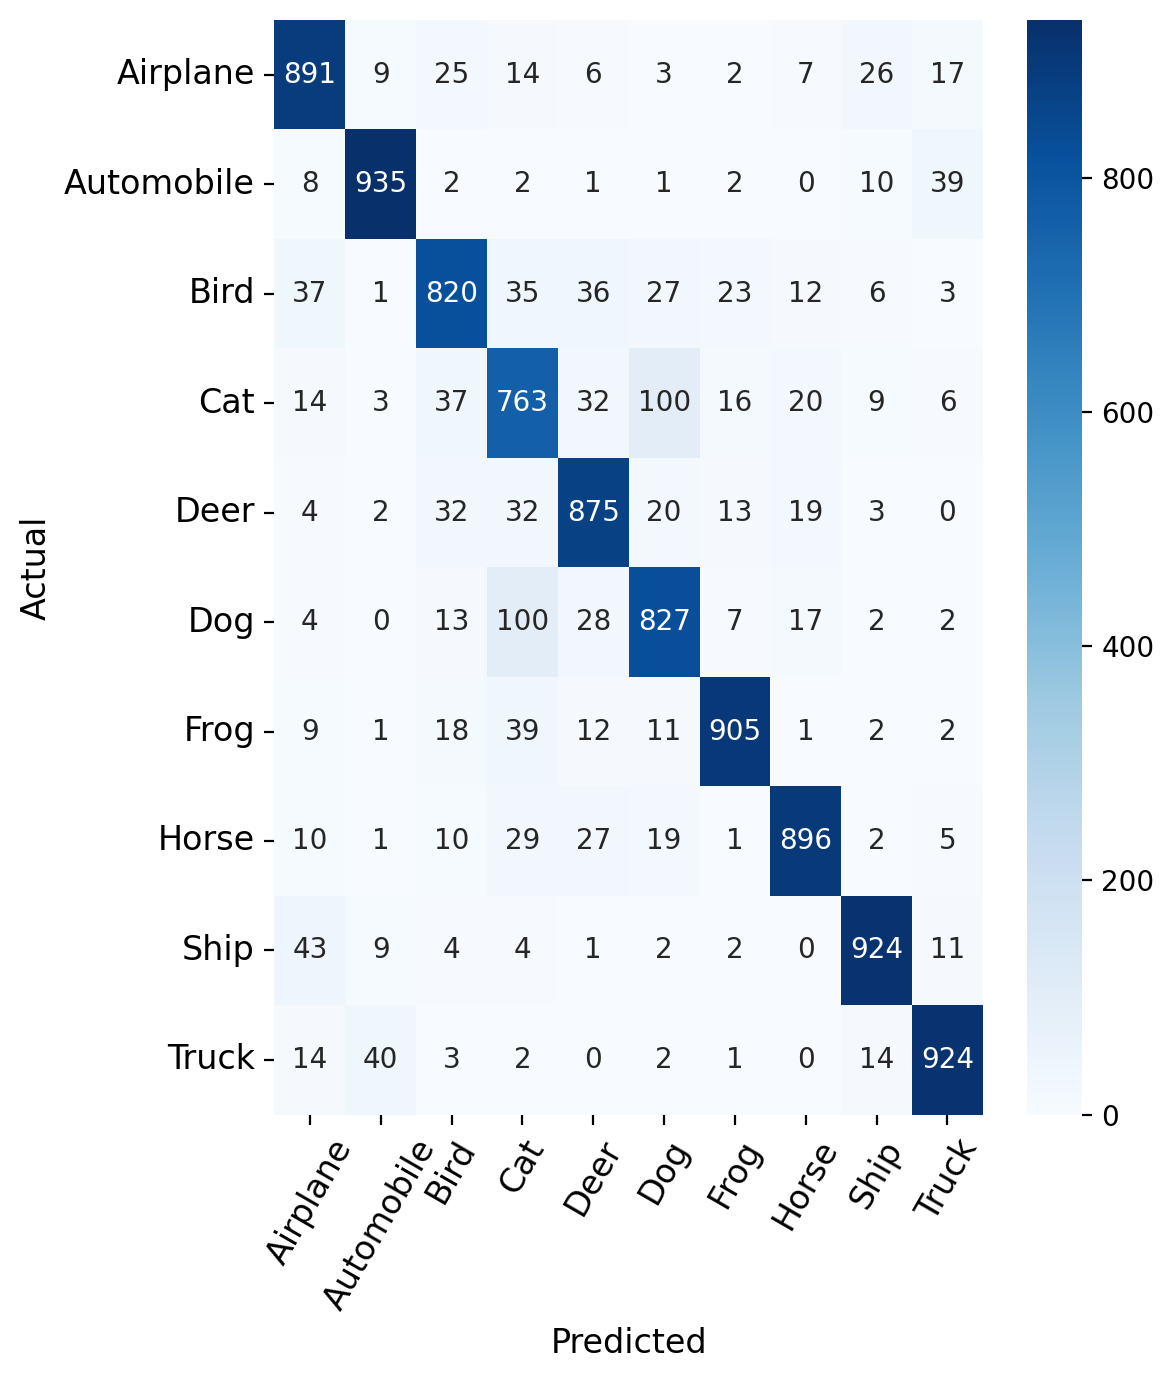

In [20]:
print("Confusion Matrix:\n", confusion_matrix)

plt.figure(figsize=(6, 7), dpi=200)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

# Set title and labels with specific color
plt.ylabel('Actual', color='black', fontsize=fontsize)
plt.xlabel('Predicted', color='black', fontsize=fontsize)

# Set the color of the ticks
plt.tick_params(axis='x', colors='black', labelsize=fontsize)
plt.tick_params(axis='y', colors='black', labelsize=fontsize)

# Set the color of the ticks
plt.xticks(rotation=60, color='black')
plt.yticks(color='black')
plt.tight_layout()


# Show and save the plot
# plt.show()
plt.savefig(base_path + "confusion_matrix_resnet.png")